In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, ArrayType, FloatType, IntegerType, StringType
import pyspark.sql.functions as f
import sys
import csv
import os

In [79]:
# Importando a biblioteca RegressionEvaluator do PySpark para avaliação de modelos de regressão
from pyspark.ml.evaluation import RegressionEvaluator

# Importando a biblioteca ALS do PySpark para filtragem colaborativa e recomendação
from pyspark.ml.recommendation import ALS

# Importando a biblioteca TrainValidationSplit do PySpark para realizar validação
# Importando também a classe ParamGridBuilder para construir um grid de parâmetros a serem testados durante a validação cruzada
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

In [48]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

In [49]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 40)
sns.set_theme(style="white")
mpl.rc('font', family='Calibri')

In [3]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [4]:
warehouse_location = "hdfs://m1.local.br:9000/user/hive/warehouse"
hive_metastore_uri = "thrift://m1.local.br:9083"
defaultFS = "hdfs://m1.local.br:9000"

# 1 - Conectando ao Hive com PySpark

In [5]:
# .config('spark.ui.port', '4040') \
spark = SparkSession.builder \
    .appName("Machine Learning - MovieLens dataset") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .config("spark.hadoop.fs.defaultFS", defaultFS) \
    .config("hive.metastore.uris", hive_metastore_uri) \
    .enableHiveSupport() \
    .getOrCreate()

spark

In [6]:
spark.catalog.refreshByPath(warehouse_location)

In [7]:
print("URI do Metastore do Hive:", spark.conf.get("hive.metastore.uris"))
print("Endereço do Hadoop (HDFS):", spark.conf.get("spark.hadoop.fs.defaultFS"))

URI do Metastore do Hive: thrift://m1.local.br:9083
Endereço do Hadoop (HDFS): hdfs://m1.local.br:9000


In [8]:
# Visualizando o nome do usuário
tables = spark.sql("SELECT current_user()")
tables.show()

+--------------+
|current_user()|
+--------------+
| Vinicius Luiz|
+--------------+



In [9]:
# Se conectando ao banco default
spark.sql("USE default")

DataFrame[]

In [10]:
# Visualizando as tabelas no database default
tables = spark.sql("SHOW tables")
tables.show()

+---------+-----------------+-----------+
|namespace|        tableName|isTemporary|
+---------+-----------------+-----------+
|  default|    genome_scores|      false|
|  default|genome_scores_tmp|      false|
|  default|      genome_tags|      false|
|  default|  genome_tags_tmp|      false|
|  default|            links|      false|
|  default|        links_tmp|      false|
|  default|           movies|      false|
|  default|       movies_tmp|      false|
|  default|          ratings|      false|
|  default|      ratings_tmp|      false|
|  default|             tags|      false|
|  default|         tags_tmp|      false|
+---------+-----------------+-----------+



In [11]:
SQL_COUNT = '''
select count(1)       as qtd_linhas
    , 'genome_scores' as table_name
  from genome_scores
union all
select count(1)       as qtd_linhas
    , 'genome_tags'   as table_name
  from genome_tags
union all
select count(1)       as qtd_linhas
    , 'movies'        as table_name
  from movies
union all
select count(1)       as qtd_linhas
    , 'ratings'       as table_name
  from ratings
union all
select count(1)       as qtd_linhas
    , 'tags'          as table_name
  from tags
union all
select count(1)       as qtd_linhas
    , 'links'         as table_name
  from links
'''

In [12]:
df_movies = spark.sql(SQL_COUNT)
df_movies.show(10, truncate=False)

+----------+-------------+
|qtd_linhas|table_name   |
+----------+-------------+
|18472128  |genome_scores|
|1128      |genome_tags  |
|86537     |movies       |
|33832162  |ratings      |
|2328315   |tags         |
|86537     |links        |
+----------+-------------+



# 2 - Definindo amostragem
O modelo ALS será treinado apenas com filmes que têm mais de **100 avaliações**. Isso pode ser importante para garantir que os filmes usados no treinamento do modelo tenham recebido um número suficiente de avaliações para gerar recomendações mais robustas e significativas.

Os números fornecidos indicam a distribuição do número de avaliações para os filmes:

- O dataset contém **83.239** filmes.
- **17.916** filmes contêm apenas 1 avaliação.
- **10.161** filmes contêm apenas 2 avaliações.
- **55.162** filmes contêm 3 avaliações ou mais.
- **43.873** filmes contêm 5 avaliações ou mais.
- **32.021** filmes contêm 10 avaliações ou mais.
- **16.116** filmes contém 50 avaliações ou mais.
- **12.253** filmes contêm 100 avaliações ou mais.
- **6.929** filmes contêm mais avaliações do que a média (406).

# 3 - Realizando a Hiperparametrização do modelo ALS

In [14]:
qtd_min_ratings = 100

SQL_AMOSTRAGEM = '''
SELECT m.movieid
     , count(1)      as qtd_ratings
  FROM ratings r
  JOIN movies m
    ON r.movieid = m.movieid
 GROUP BY m.movieid
 HAVING count(1) >= {qtd_min_ratings}
'''

df_movies_sample = spark.sql(SQL_AMOSTRAGEM.format(qtd_min_ratings = qtd_min_ratings))
df_movies_sample.count()

12253

In [15]:
df_movies_sample.createOrReplaceTempView("movies_sample")

In [17]:
SQL_RATINGS ='''
SELECT r.userid
     , r.movieid
     , r.rating
 FROM ratings r
 JOIN movies_sample ms
   ON r.movieid = ms.movieid
'''

ratings = spark.sql(SQL_RATINGS)
ratings = ratings.withColumn("userid", f.col("userid").cast("long"))

ratings.show(5, truncate=False)
ratings.printSchema()
ratings.count()

+------+-------+------+
|userid|movieid|rating|
+------+-------+------+
|9     |474    |4.0   |
|22    |106100 |5.0   |
|24    |474    |4.5   |
|24    |6721   |3.0   |
|30    |72011  |4.0   |
+------+-------+------+
only showing top 5 rows

root
 |-- userid: long (nullable = true)
 |-- movieid: long (nullable = true)
 |-- rating: decimal(10,1) (nullable = true)



33060369

In [18]:
# Separando os dados em 70% para o treinamento e 30% para a validação
(train, test) = ratings.randomSplit([0.7, 0.3])

In [19]:
# Criando um modelo ALS
# Parâmetros:
# - userCol: Nome da coluna que contém os IDs dos usuários
# - itemCol: Nome da coluna que contém os IDs dos itens (por exemplo, filmes)
# - ratingCol: Nome da coluna que contém as classificações atribuídas pelos usuários aos itens
# - coldStartStrategy: Estratégia para lidar com novos usuários ou itens durante a previsão ("drop" irá descartar)
# - nonnegative: Se True, restringe os fatores latentes a valores não negativos

als = ALS(userCol="userid", itemCol="movieid", ratingCol="rating",
          coldStartStrategy="drop", nonnegative=True)

In [20]:
# Criando um grid de parâmetros para hiperparametrização do modelo ALS usando ParamGridBuilder

# rank: número de fatores latentes
# maxIter: número máximo de iterações
# regParam: parâmetro de regularização
param_grid = ParamGridBuilder()\
            .addGrid(als.rank, [10, 15, 20])\
            .addGrid(als.maxIter, [5, 10, 15])\
            .addGrid(als.regParam, [0.01, .1, .5])\
            .build()

In [21]:
# Definindo um avaliador para a métrica RMSE (Root Mean Squared Error)

# Parâmetros:
# - metricName: Nome da métrica a ser avaliada, neste caso, "rmse" para o Root Mean Squared Error
# - labelCol: Nome da coluna que contém os rótulos reais (neste caso, as classificações atribuídas pelos usuários)
# - predictionCol: Nome da coluna que contém as previsões geradas pelo modelo

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

In [22]:
# Criando um objeto TrainValidationSplit no PySpark para realizar a divisão entre treino e validação durante a validação cruzada

# Parâmetros:
# - estimator: Estimador a ser validado, neste caso, o modelo ALS que foi criado anteriormente
# - estimatorParamMaps: Grid de parâmetros a serem testados durante a validação cruzada
# - evaluator: Avaliador a ser usado para avaliar o desempenho do modelo em diferentes configurações

train_validation = TrainValidationSplit(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
)

In [23]:
# Treinando o modelo
model = train_validation.fit(train)

In [24]:
# Obtendo o melhor modelo
best_model = model.bestModel
best_model

ALSModel: uid=ALS_b76d695af141, rank=20

In [25]:
# Gerando as previsões
predictions = best_model.transform(test)
predictions.show(5, truncate=False)

+------+-------+------+----------+
|userid|movieid|rating|prediction|
+------+-------+------+----------+
|28    |135    |1.0   |2.2751474 |
|28    |593    |4.0   |3.7553833 |
|28    |2184   |4.0   |3.2852948 |
|28    |2559   |3.0   |2.1906624 |
|31    |47     |3.0   |2.764629  |
+------+-------+------+----------+
only showing top 5 rows



In [26]:
# Avaliando o modelo
rmse = evaluator.evaluate(predictions)

Considerando que os ratings variam de 0 a 5, o Root Mean Square Error (RMSE) de **0.809221** indica que, em média, as previsões do modelo têm uma discrepância de aproximadamente 0.809221 unidades em relação aos valores reais em uma escala de 0 a 5. O termo "root" no RMSE implica que os erros foram primeiro elevados ao quadrado, acentuando a penalização dos erros maiores. A aplicação da raiz quadrada então retorna a métrica à mesma escala dos dados originais.

In [27]:
# Mostrando os resultados
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Rank = %d" % best_model.rank)
print("MaxIter = %d" % best_model._java_obj.parent().getMaxIter())
print("RegParam = %g" % best_model._java_obj.parent().getRegParam())

Root Mean Squared Error (RMSE) on test data = 0.809221
Rank = 20
MaxIter = 15
RegParam = 0.1


In [51]:
# Mostrando as previsões
predictions.sort('userid', 'rating')
predictions.show(5, False)

+------+-------+------+----------+
|userid|movieid|rating|prediction|
+------+-------+------+----------+
|28    |135    |1.0   |2.2751474 |
|28    |593    |4.0   |3.7553833 |
|28    |2184   |4.0   |3.2852948 |
|28    |2559   |3.0   |2.1906624 |
|31    |47     |3.0   |2.764629  |
+------+-------+------+----------+
only showing top 5 rows



# 4 - Gerando recomendações para todos os usuários usando o emlhor modelo obtido após o treino

In [29]:
# Parâmetros:
# - best_model: O modelo que apresentou o melhor desempenho após a validação cruzada
# - recommendForAllUsers(10): Gerando recomendações para todos os usuários, onde 10 é o número de itens a serem recomendados para cada usuário
user_recs = best_model.recommendForAllUsers(10)

c:\Users\Vinicius Luiz\Desktop\Scripts\movie_recommendation_pyspark\venv\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [47]:
# Gerando recomendações para um usuário
def get_recommendations_for_user(recs):
    # Explodir a coluna de recomendações
    df_exploded = recs.select("userid", f.explode("recommendations").alias("rec"))

    # Selecionar as colunas desejadas
    df_transformed = df_exploded.select("rec.movieid", "rec.rating")

    # Renomear as colunas
    df_transformed = df_transformed.withColumnRenamed("rec.movieid", "movieid") \
                                   .withColumnRenamed("rec.rating", "rating")

    return df_transformed

In [48]:
# Gerando recomendações pro usuário 1

user_1 = user_recs.filter("userid = 1")

user_1.show(truncate = False)
user_1.printSchema()

+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userid|recommendations                                                                                                                                                                               |
+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1     |[{318, 4.202657}, {182723, 4.170433}, {356, 4.1683593}, {1035, 4.163223}, {115969, 4.160298}, {364, 4.1588306}, {88125, 4.15752}, {176887, 4.1508374}, {159817, 4.1487494}, {4896, 4.1294866}]|
+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+


**Recomendação final de 10 filmes para o usuário 1**

In [50]:
user_1_transformed = get_recommendations_for_user(user_1)
user_1_transformed.show(50, truncate=False)

+-------+---------+
|movieid|rating   |
+-------+---------+
|318    |4.202657 |
|182723 |4.170433 |
|356    |4.1683593|
|1035   |4.163223 |
|115969 |4.160298 |
|364    |4.1588306|
|88125  |4.15752  |
|176887 |4.1508374|
|159817 |4.1487494|
|4896   |4.1294866|
+-------+---------+



# 4 - Definindo o modelo

In [416]:
class Recommender():
    '''
Root Mean Squared Error (RMSE) on test data = 0.809221
Rank = 20
MaxIter = 15
RegParam = 0.1
    '''
    def __init__(self, rank: int = 20, maxIter: int = 15, regParam: float = 0.1):
        self.model = None
        self.ratings = None

        self.rank = rank
        self.maxIter = maxIter
        self.regParam = regParam

        self.schema = StructType([
            StructField("userid", IntegerType()),
            StructField("recommendations", ArrayType(StructType([
                StructField("movieid", IntegerType()),
                StructField("rating", FloatType())
            ])))
        ])

    def prepare_data(self, sql: str):
        '''Cria um DataFrame a partir de um SQL.'''
        self.ratings = spark.sql(sql)
        self.ratings = self.ratings.withColumn("userid", f.col("userid").cast("long"))
    
    def fit(self, coldStartStrategy: str = 'drop'):
        '''Treinando o Modelo'''
        als = ALS(userCol="userid", itemCol="movieid", ratingCol="rating",
                  coldStartStrategy=coldStartStrategy, nonnegative=True,
                  rank=self.rank, maxIter=self.maxIter, regParam=self.regParam)

        self.model = als.fit(self.ratings)
    
    def prepare_user_ratings(self, userid: int, user_ratings: list, create_view: bool = False):
        '''Cria um DataFrame a partir das avaliações do usuário'''
        user = [
            (userid, user_ratings)
        ]

        df_user_ratings =  spark.createDataFrame(user, schema=self.schema)

        if create_view:
            df_user_ratings.createOrReplaceTempView("user_ratings")
        
        return df_user_ratings
    
    def recommend_for_user(self, user_ratings, numItems: int, create_view: str = None):
        '''Gerando recomendações para um conjunto de usuários'''
        recs = self.model.recommendForUserSubset(user_ratings, numItems=numItems)

        df_exploded = recs.select("userid", f.explode("recommendations").alias("rec"))

        df_transformed = df_exploded.select("rec.movieid", "rec.rating")

        df_transformed = df_transformed.withColumnRenamed("rec.movieid", "movieid") \
                                        .withColumnRenamed("rec.rating", "rating")
        
        if create_view:
            df_transformed.createOrReplaceTempView(create_view)

        return df_transformed
    
    def show_recommendations(self, n: int, view_name: str):
        SQL_RECOMENDATIONS  = '''
            SELECT r.movieid
                , m.title
                , round(r.rating, 1) as rating
                , m.genres
            FROM {view_name} r
            JOIN movies m
                ON r.movieid = m.movieid
            '''

        spark.sql(SQL_RECOMENDATIONS.format(view_name=view_name)).show(n, truncate=False)

# 5 - Utilizando modelo com base nas minhas avaliações

## 5.1 - Análise das minhas avaliações

In [417]:
USERID = 87

In [418]:
# Obtendo minhas avaliações do arquivo csv
USER_RATINGS = []

USER_RATING_TO_DF = []

with open('my_movies.csv', newline='', encoding='utf-8') as file:
    csv_file = csv.reader(file)

    cabecalho = next(csv_file)

    for movie in csv_file:
        movie =  dict(zip(cabecalho, movie))

        movie = {
            'movie': movie['movie'],
            'movieid': int(movie['movieid']),
            'rating': float(movie['rating'])
        }
        
        USER_RATINGS.append( (movie['movieid'], movie['rating']) )
        
        USER_RATING_TO_DF.append(movie)

```python
[
    (49272, 3.5),
    (136020, 3.5),
    (96079, 3.5),
    (63113, 3.5),
    ...
]
```

In [419]:
# Definindo o esquema do DataFrame
schema = StructType([
    StructField("movie", StringType(), nullable=True),
    StructField("movieid", IntegerType(), nullable=True),
    StructField("rating", FloatType(), nullable=True)
])

In [420]:
# Criando um DataFrame a partir das minhas avaliações 
my_movies = spark.createDataFrame(USER_RATING_TO_DF, schema=schema)
my_movies.show(10, truncate = False)

my_movies.createOrReplaceTempView("my_movies")

+---------------------------+-------+------+
|movie                      |movieid|rating|
+---------------------------+-------+------+
|007 - Cassino Royale       |49272  |3.5   |
|007 - Contra Spectre       |136020 |3.5   |
|007 - Operação Skyfall     |96079  |3.5   |
|007 - Quantum of Solace    |63113  |3.5   |
|007 - Sem Tempo para Morrer|224280 |3.5   |
|1917                       |208703 |4.0   |
|500 Dias Com Ela           |69757  |4.0   |
|A Familia do Futuro        |52287  |4.0   |
|A Vida De David Gale       |47200  |4.0   |
|Alemão                     |164284 |3.0   |
+---------------------------+-------+------+
only showing top 10 rows



In [421]:
# Enriquecendo o DataFrame
SQL_MY_MOVIES = '''
SELECT my.movie
     , my.movieid
     , my.rating
     , m.year
     , m.genres
 FROM my_movies my
 JOIN movies m
   ON my.movieid = m.movieid
'''

my_movies = spark.sql(SQL_MY_MOVIES)
my_movies.show(10, truncate = False)

my_movies.createOrReplaceTempView("my_movies")

+---------------------------+-------+------+----+--------------------------------------------------------+
|movie                      |movieid|rating|year|genres                                                  |
+---------------------------+-------+------+----+--------------------------------------------------------+
|007 - Cassino Royale       |49272  |3.5   |2006|[Action, Adventure, Thriller]                           |
|007 - Contra Spectre       |136020 |3.5   |2015|[Action, Adventure, Crime]                              |
|007 - Operação Skyfall     |96079  |3.5   |2012|[Action, Adventure, Thriller, IMAX]                     |
|007 - Quantum of Solace    |63113  |3.5   |2008|[Action, Adventure, Thriller]                           |
|007 - Sem Tempo para Morrer|224280 |3.5   |2020|[Action, Adventure, Mystery, Thriller]                  |
|1917                       |208703 |4.0   |2019|[Drama, War]                                            |
|500 Dias Com Ela           |69757  |

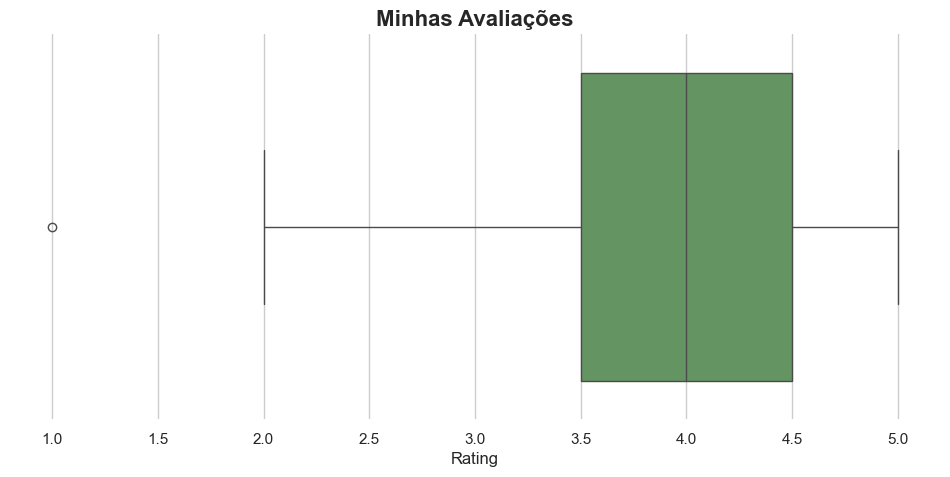

In [422]:
plt.figure(figsize=(12, 5))

sns.set_style("whitegrid", {
        'axes.spines.bottom': False, 'axes.spines.left': False,
        'axes.spines.right': False, 'axes.spines.top': False
    })

sns.boxplot(x='rating', data=my_movies.toPandas(), color='#5D9C59')


plt.title('Minhas Avaliações', fontsize = 16, fontweight = 'bold')
plt.xlabel('Rating')
plt.show()

In [423]:
SQL_MY_MOVIES_GENRES = '''
SELECT genres
     , rating
 FROM my_movies
'''

my_movies_genres = spark.sql(SQL_MY_MOVIES_GENRES)
my_movies_genres = my_movies_genres.select(f.explode("genres").alias("genre"), 'rating')

my_movies_genres.createOrReplaceTempView('my_movies_genres_explode')

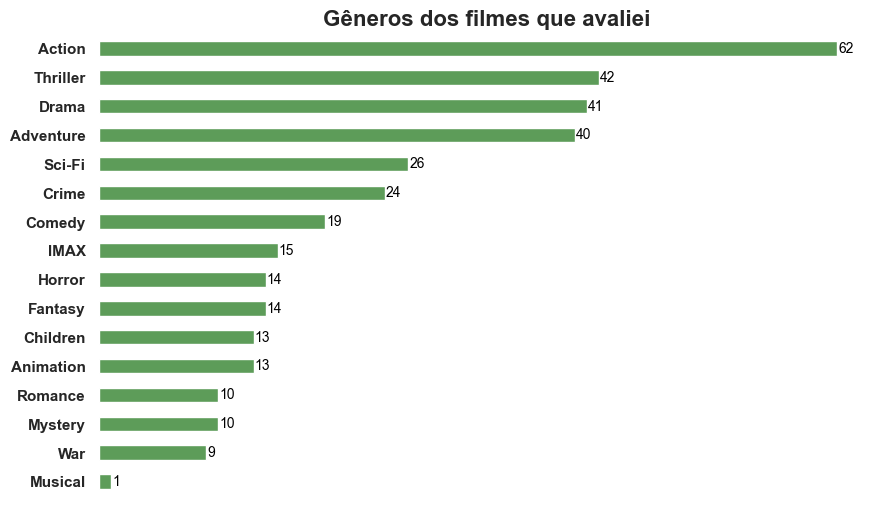

In [424]:
genre_counts = my_movies_genres.toPandas()['genre']\
                               .value_counts(ascending = True)


sns.set_style("white", {
        'axes.spines.bottom': False, 'axes.spines.left': False,
        'axes.spines.right': False, 'axes.spines.top': False
    })

plt.figure(figsize=(10, 6))
ax = genre_counts.plot(kind='barh', color='#5D9C59')

plt.title('Gêneros dos filmes que avaliei', fontsize = 16, fontweight = 'bold')
plt.xlabel('')
plt.ylabel('')

ax.set_xticks([])
plt.yticks(fontweight='bold')

for i, v in enumerate(genre_counts):
    ax.text(v + 0.1, i, str(v), color='black', va='center', fontsize=10)

plt.show()

In [425]:
SQL_MY_MOVIES_GENRES_RESUMED = '''
SELECT genre
     , ROUND((SUM(ruim)    / COUNT(1)) * 100, 2) AS ruim
     , ROUND((SUM(mediano) / COUNT(1)) * 100, 2) AS mediano
     , ROUND((SUM(bom)     / COUNT(1)) * 100, 2) AS bom
FROM (
    SELECT genre
         , rating
         , CASE WHEN rating < 3 THEN 1 ELSE 0 END               AS ruim
         , CASE WHEN rating BETWEEN 3 AND 3.9 THEN 1 ELSE 0 END AS mediano
         , CASE WHEN rating >= 4 THEN 1 ELSE 0 END              AS bom
    FROM my_movies_genres_explode
) 
GROUP BY genre
'''
my_movies_genres_resumed = spark.sql(SQL_MY_MOVIES_GENRES_RESUMED)
my_movies_genres_resumed = my_movies_genres_resumed.toPandas()\
                                                  .sort_values('bom', ascending=False)

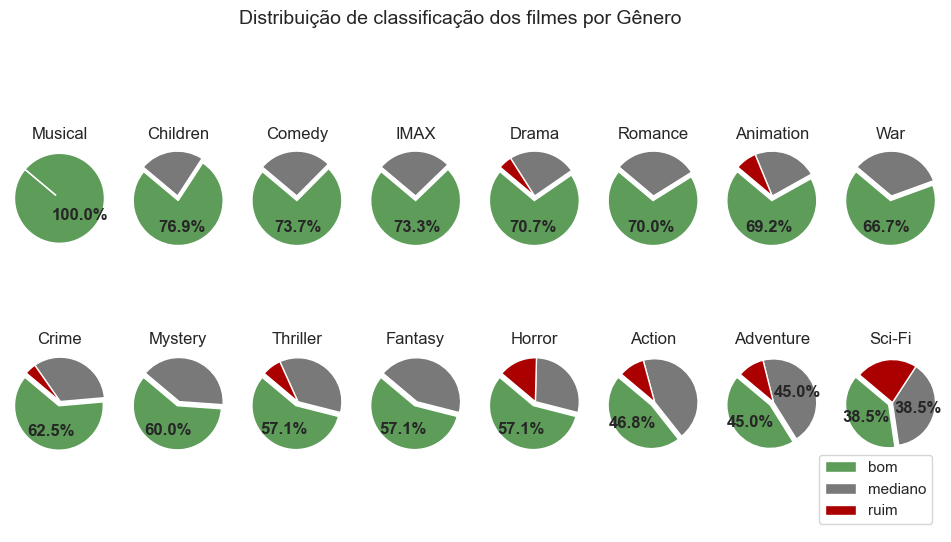

In [466]:
num_linhas = 2
num_colunas = len(my_movies_genres_resumed) // num_linhas + (len(my_movies_genres_resumed) % num_linhas > 0)

genres = my_movies_genres_resumed['genre'].unique()

fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(12, 6))
fig.subplots_adjust(hspace=-0.2)  # Ajuste a margem entre as linhas aqui

labels = ['bom', 'mediano', 'ruim']
colors = ['#5D9C59', '#797979', '#ab0000']

def autopct_label(pct, sizes):
    return f'{pct:.1f}%' if round(pct, 2) in (sizes[0], sizes[0]+.01) else ''

for i, genre in enumerate(genres):
    row = i // num_colunas
    col = i % num_colunas

    subset_data = my_movies_genres_resumed[my_movies_genres_resumed['genre'] == genre]
    sizes = [subset_data['bom'].values[0], subset_data['mediano'].values[0], subset_data['ruim'].values[0]]
    explode = (0.1, 0, 0)

    axs[row, col].pie(sizes, colors=colors, autopct=lambda pct: autopct_label(pct, sizes), startangle=140, explode=explode, textprops={'fontweight': 'bold'})
    axs[row, col].set_title(genre, y=.7)
    axs[row, col].axis('equal')

# Remova subplots não utilizados
for i in range(len(genres), num_linhas * num_colunas):
    fig.delaxes(axs.flatten()[i])

plt.legend(labels, loc='lower right')
plt.suptitle(f'Distribuição de classificação dos filmes por Gênero', fontsize=14)

plt.show()


## 5.2 - Recomendando filmes
**A base de dados possui avaliações até 07/2023**

In [427]:
# Traça os filmes com pelo menos 100 avaliações
SQL_MOVIES_SAMPLE = '''
    SELECT m.movieid
         , count(1)      as qtd_ratings
      FROM ratings r
      JOIN movies m
        ON r.movieid = m.movieid
    GROUP BY m.movieid
    HAVING count(1) >= 100
'''

spark.sql(SQL_MOVIES_SAMPLE)\
    .createOrReplaceTempView("movies_sample")

In [428]:
# Traça todos os filmes aptos a treinamento
SQL_RATINGS_TRAIN = ''' 
SELECT r.userid
     , r.movieid
     , r.rating
     , m.genres
     , r.rating_date
 FROM ratings r
 JOIN movies m
   ON r.movieid = m.movieid
 JOIN movies_sample ms
   ON r.movieid = ms.movieid
WHERE 1=1
'''

spark.sql(SQL_RATINGS_TRAIN)\
    .createOrReplaceTempView("ratings_train")

In [429]:
# Traça gênero dos filmes
SQL_MOVIES_GENRES = '''
SELECT m.movieid
     , m.genres
  FROM movies m
'''

spark.sql(SQL_MOVIES_GENRES)\
     .select("movieid", f.explode("genres").alias("genres"))\
     .createOrReplaceTempView('movies_genres')

In [430]:
NUM_FILMES = 20

### 5.2.1 - Geral

In [431]:
VIEW_NAME = 'user_recs_geral'

In [434]:
SQL_RATINGS_GERAL = ''' 
SELECT r.userid
     , r.movieid
     , r.rating
 FROM ratings_train r
'''

In [435]:
recommender = Recommender()
recommender.prepare_data(SQL_RATINGS_GERAL)
recommender.fit()

In [436]:
user_ratings = recommender.prepare_user_ratings(USERID, USER_RATINGS)
user_recomendations = recommender.recommend_for_user(user_ratings, numItems=NUM_FILMES, create_view=VIEW_NAME)

c:\Users\Vinicius Luiz\Desktop\Scripts\movie_recommendation_pyspark\venv\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [437]:
recommender.show_recommendations(n=NUM_FILMES, view_name=VIEW_NAME)

+-------+-----------------------------------------+------+-------------------------------------------------------+
|movieid|title                                    |rating|genres                                                 |
+-------+-----------------------------------------+------+-------------------------------------------------------+
|2959   |Fight Club (1999)                        |4.3   |[Action, Crime, Drama, Thriller]                       |
|3761   |Blood In, Blood Out (1993)               |4.3   |[Action, Crime, Drama, Thriller]                       |
|176601 |Black Mirror                             |4.3   |[(no genres listed)]                                   |
|179053 |2048: Nowhere to Run (2017)              |4.3   |[Sci-Fi, Thriller]                                     |
|170705 |Band of Brothers (2001)                  |4.2   |[Action, Drama, War]                                   |
|47     |Seven (a.k.a. Se7en) (1995)              |4.2   |[Mystery, Thriller]   

### 5.2.2 - Filmes de animação-comédia para crianças

In [438]:
VIEW_NAME = 'user_recs_cca'

In [439]:
# Traça somentes avaliações de filmes do gêneros: Children & Comedy & Animation
SQL_RATINGS_CCA = '''
SELECT r.userid
     , r.movieid
     , r.rating
  FROM ratings_train r
 WHERE 1=1
   AND ARRAY_CONTAINS(r.genres, 'Children')
   AND ARRAY_CONTAINS(r.genres, 'Comedy')
   AND ARRAY_CONTAINS(r.genres, 'Animation')
'''

In [440]:
recommender = Recommender()
recommender.prepare_data(SQL_RATINGS_CCA)
recommender.fit()

In [441]:
user_ratings = recommender.prepare_user_ratings(USERID, USER_RATINGS)
user_recomendations = recommender.recommend_for_user(user_ratings, numItems=NUM_FILMES, create_view=VIEW_NAME)

In [442]:
recommender.show_recommendations(n=NUM_FILMES, view_name=VIEW_NAME)

+-------+-------------------------------------------+------+--------------------------------------------------------+
|movieid|title                                      |rating|genres                                                  |
+-------+-------------------------------------------+------+--------------------------------------------------------+
|134853 |Inside Out (2015)                          |0.5   |[Adventure, Animation, Children, Comedy, Drama, Fantasy]|
|1      |Toy Story (1995)                           |0.5   |[Adventure, Animation, Children, Comedy, Fantasy]       |
|78499  |Toy Story 3 (2010)                         |0.5   |[Adventure, Animation, Children, Comedy, Fantasy, IMAX] |
|134849 |Duck Amuck (1953)                          |0.5   |[Animation, Children, Comedy]                           |
|3114   |Toy Story 2 (1999)                         |0.5   |[Adventure, Animation, Children, Comedy, Fantasy]       |
|163066 |Rabbit Seasoning (1952)                    |0.5

### 5.2.3 - Filmes para quem gostou de Velozes e Furiosos

In [443]:
VIEW_NAME = 'user_recs_ff'

In [444]:
# Traça usuários que avaliaram positivamente os filmes da saga Velozes e Furiosos
SQL_USERS_FF = '''
SELECT DISTINCT r.userid
  FROM ratings_train r
 WHERE r.movieid in (4369
                    ,6383
                    ,46335
                    ,67923
                    ,86644
                    ,102716
                    ,130634
                    ,170875
                    ,249964)
 GROUP BY r.userid
HAVING avg(r.rating) >= 4.0
'''

spark.sql(SQL_USERS_FF)\
    .createOrReplaceTempView("ratings_users_ff")

In [445]:
# Traça filmes Avaliados por quem gostou dos filmes da saga Velozes e Furiosos
SQL_RATINGS_FF = '''
SELECT r.userid
     , r.movieid
     , r.rating
  FROM ratings_train r
  JOIN ratings_users_ff u
    ON u.userid = r.userid
'''

In [446]:
recommender = Recommender()
recommender.prepare_data(SQL_RATINGS_FF)
recommender.fit()

In [447]:
user_ratings = recommender.prepare_user_ratings(USERID, USER_RATINGS)
user_recomendations = recommender.recommend_for_user(user_ratings, numItems=NUM_FILMES, create_view=VIEW_NAME)

In [448]:
recommender.show_recommendations(n=NUM_FILMES, view_name=VIEW_NAME)

+-------+-------------------------------------------------------------------------------------+------+---------------------------------+
|movieid|title                                                                                |rating|genres                           |
+-------+-------------------------------------------------------------------------------------+------+---------------------------------+
|1365   |Ridicule (1996)                                                                      |5.0   |[Drama]                          |
|103017 |The Body (2012)                                                                      |4.9   |[Mystery, Thriller]              |
|33649  |Saving Face (2004)                                                                   |4.9   |[Comedy, Drama, Romance]         |
|4547   |Stormy Monday (1988)                                                                 |4.8   |[Crime, Drama]                   |
|7562   |Dobermann (1997)                